In [1]:
%load_ext autotime

time: 374 µs (started: 2021-10-04 20:37:37 -03:00)


In [2]:
import numpy as np
from scipy import integrate
import plotly.express as px
from dataclasses import dataclass
import pandas as pd

@dataclass
class SimulationParameters():
    Nt: int
    tmax: float


@dataclass
class ModelParameters():
    alpha: float
    beta: float
    delta: float
    gamma: float
    
@dataclass
class InitialState():
    x: float
    y: float

@dataclass
class Model():
    
    X0: InitialState
    params: ModelParameters
    config: SimulationParameters
    
    def derivative(self, X, t):
        x, y = X
        dotx = x * (self.params.alpha - self.params.beta * y)
        doty = y * (-self.params.delta + self.params.gamma * x)
        return np.array([dotx, doty])
    
    def simulate(self):
        t = np.linspace(0.,self.config.tmax, self.config.Nt)
        res = integrate.odeint(self.derivative, 
                               tuple(self.X0.__dict__.values()), 
                               t)
        x, y = res.T
        return (t, x, y)
        

initial_state = InitialState(4, 2)
params = ModelParameters(alpha=0.5, beta=0.5, delta=1.5, gamma=2)
config = SimulationParameters(100_000, 3_000)

model = Model(initial_state, params, config)
results = model.simulate()
(t, x, y) = results
data = {'t': t, 'x': x, 'y': y}
df = pd.DataFrame(data).set_index('t')
df.head(3)

,x,y
t,,
0.000000,4.000000,2.000000
0.030000,3.928243,2.425691
0.060001,3.831069,2.927156


time: 998 ms (started: 2021-10-04 20:37:37 -03:00)


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from deeptime.sindy import STLSQ

t = df.index
X = df.values

library = PolynomialFeatures(degree=3)
optimizer = STLSQ(threshold=0.2)

from deeptime.sindy import SINDy

# Instantiate the estimator
estimator = SINDy(
    library=library,
    optimizer=optimizer,
    input_features=["x", "y"]  # The feature names are just for printing
)

# Fit the estimator to data
estimator.fit(X, t=t);
model = estimator.fetch_model();
model.print()

x' = 0.499 x + -0.499 x y
y' = -1.496 y + 1.995 x y
time: 326 ms (started: 2021-10-04 20:37:38 -03:00)


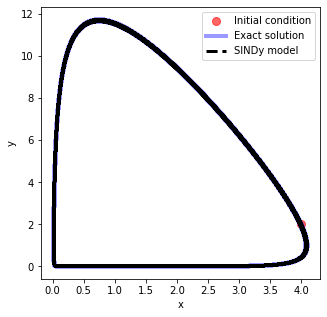

time: 3.48 s (started: 2021-10-04 20:37:38 -03:00)


In [4]:
x0 = initial_state.x
y0 = initial_state.y

t_test = np.linspace(0, config.tmax, config.Nt)
x_test = df.x
y_test = df.y

sim = model.simulate([x0, y0], t=t_test)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
ax.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
ax.set(xlabel="x", ylabel="y")
ax.legend();